In [1]:
import rasterio as rio
from rasterio.plot import show
import torch
import segmentation_models_pytorch as smp
from Utils import presentation_utils as pu
import numpy as np
import random
from glob import glob
from termcolor import colored
import os

/home/adsp/miniconda3/envs/adspenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
! rm tmp/predictions/*
! rm tmp/tiles/*
! rm tmp/example.tif

In [3]:
random.seed(51996)
np.random.seed(51996)
torch.manual_seed(51996)

In [4]:
MODELS = {
    "vanilla":12,
    "ben":12,
    "imagenet":10,
    # "effis":12
}
IMAGES = {
    "img_0" : ["tmp/test_img.tiff", "tmp/test_mask.tiff"],
    "img_1" : ["tmp/test_img_1.tiff", "tmp/test_mask_1.tiff"]
}

Tiling test image...


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


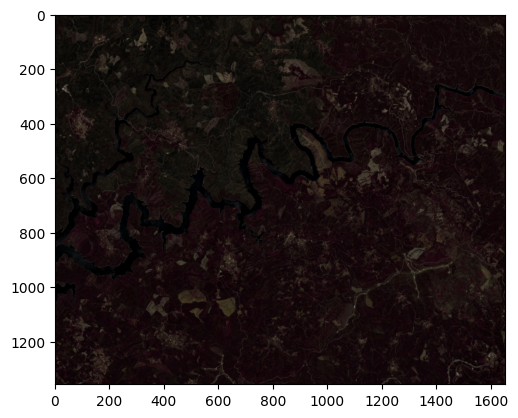

/home/adsp/miniconda3/envs/adspenv/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


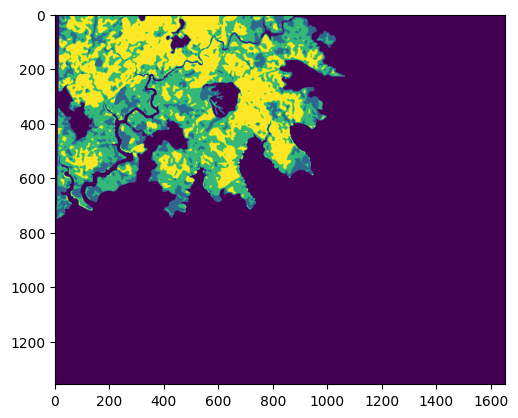

Loading initial image into memory...
Test image shape: (13, 1357, 1653)
Computing tiles...
Testing model: vanilla; input channels: 12
Making prediction...


  0%|          | 0/12 [00:00<?, ?it/s]/home/adsp/miniconda3/envs/adspenv/lib/python3.9/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
100%|██████████| 12/12 [00:02<00:00,  5.55it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)


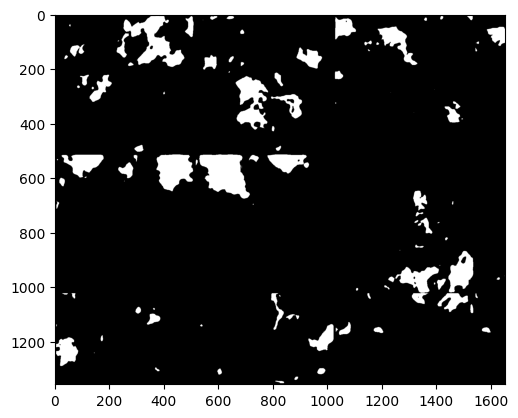

Removing existing predictions...
Testing model: ben; input channels: 12
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  4.97it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)


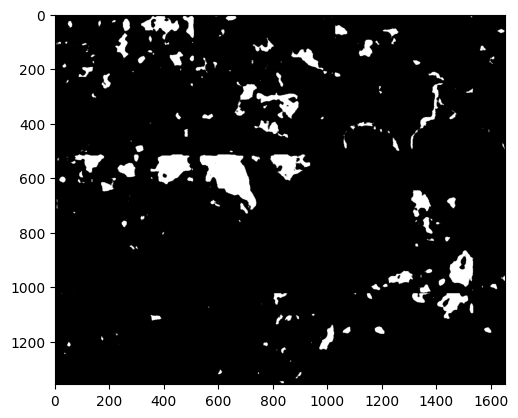

Removing existing predictions...
Testing model: imagenet; input channels: 10
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  5.21it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)


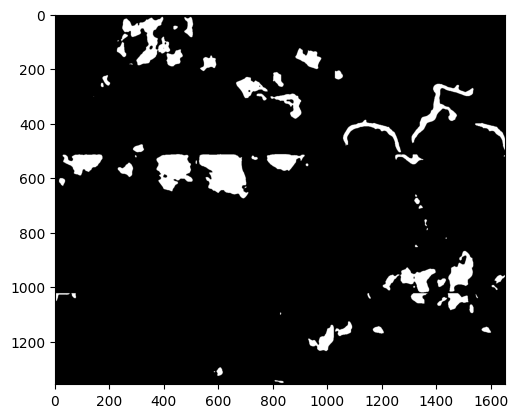

Removing existing predictions...
Tiling test image...


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


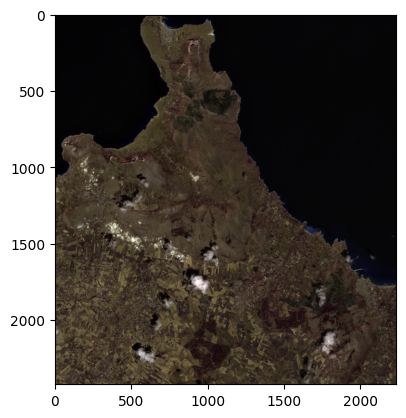

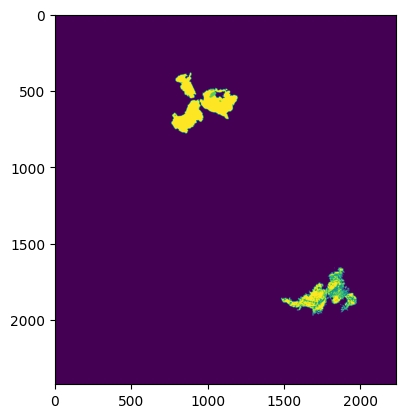

Loading initial image into memory...
Test image shape: (13, 2422, 2236)
Computing tiles...
Testing model: vanilla; input channels: 12
Making prediction...


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 2422, 2236)


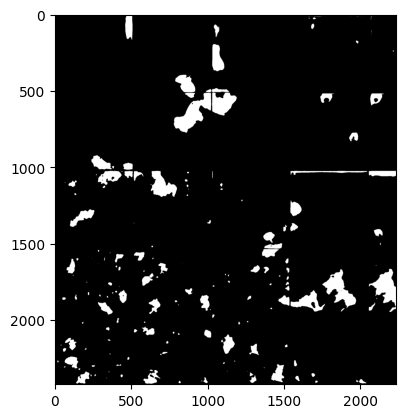

Removing existing predictions...
Testing model: ben; input channels: 12
Making prediction...


100%|██████████| 25/25 [00:05<00:00,  4.76it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 2422, 2236)


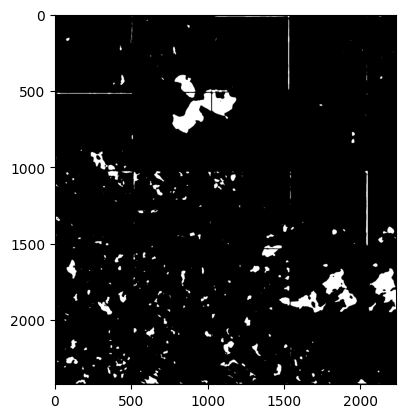

Removing existing predictions...
Testing model: imagenet; input channels: 10
Making prediction...


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 2422, 2236)


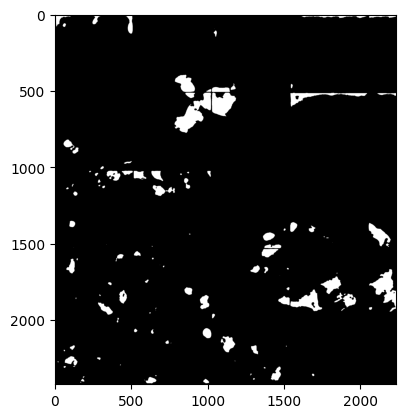

Removing existing predictions...


In [5]:
for image, mask in IMAGES.values(): 
    print("Tiling test image...")
    initial_img = rio.open(image, "r").read()
    initial_img = initial_img[[4, 3, 2], :, :]
    show(initial_img)
    gt_mask = rio.open(mask, "r").read()
    show(gt_mask)
    pu.tiling(initial_img_path=image)
    for mdl, in_c in MODELS.items():
        print(colored(f"Testing model: {mdl}; input channels: {in_c}", "red"))
        model = smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=in_c, classes=1)
        model.load_state_dict(torch.load(f"models/trained_models/{mdl}.pth"), strict=False)
        # print("Tiling test image...")
        # pu.tiling(initial_img_path="tmp/test_img.tiff")
        print("Making prediction...")
        pu.make_predictions(model=model, model_type=mdl)
        print("Assembling final prediction...")
        final_prediction, shape_crop = pu.merge_tiles(test_img_path=image)
        show(final_prediction[:, :, 512:shape_crop+512],  cmap="gray")
        pu.write_results(final_img = final_prediction)
        print(colored(f"Removing existing predictions...", "green"))
        for prediction in glob("tmp/predictions/*.tif"):
            os.remove(prediction)
    for tile in glob("tmp/tiles/*.tif"):
        os.remove(tile)